# Model bias analysis

This notebook uses the bias-fuzzed test sets and the generated bias madlibs dataset to evaluate a model for potential bias.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Model loading and inference

In [2]:
# TODO(jetpack): rewrite this to use nthain's library

import cPickle
import os

from keras.models import load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

MODEL_VERSION = 'wiki_tox_labels_v0'
MODEL_DIR = '../models/'

# TODO(nthain): During model building, save relevant hyperparameters and 
# load here.
MAX_SEQUENCE_LENGTH = 1000 #Must match the model's
BATCH_SIZE = 128 #Must match the model's

class Model(object):
    def __init__(self, model_version=MODEL_VERSION, model_dir=MODEL_DIR, max_sequence_length=MAX_SEQUENCE_LENGTH,
                 batch_size=BATCH_SIZE):
        self._max_sequence_length = max_sequence_length
        self._batch_size = batch_size
        self._tokenizer = cPickle.load(open(os.path.join(model_dir, '%s_tokenizer.pkl' % model_version), 'rb'))
        self._model = load_model(os.path.join(model_dir, '%s_model.h5' % model_version))

    def score(self, texts):
        sequences = self._tokenizer.texts_to_sequences(texts)
        data = pad_sequences(sequences, maxlen=self._max_sequence_length)
        return self._model.predict(data, batch_size=self._batch_size)[:, 1]

Using TensorFlow backend.


In [3]:
model = Model()

In [4]:
model.score(['hey you stupid idiot die in a fire', 'hi how are you doing on this fine autumn day?'])

array([ 0.99973911,  0.01944214], dtype=float32)

# Model evaluation

In [5]:
from sklearn import metrics

def compute_auc(y_true, y_pred):
    fpr, tpr, _thresholds = metrics.roc_curve(y_true, y_pred)
    return metrics.auc(fpr, tpr)

def compute_model_auc(model, examples, labels):
    scores = model.score(examples)
    return compute_auc(labels, scores)

In [6]:
compute_model_auc(model,
                  ['hey you stupid idiot die in a fire', 'hi how are you doing on this fine autumn day?'],
                  [True, False])

1.0

# Bias evaluation: bias madlibs dataset

This dataset is generated from templates and word lists. See [the docs](https://github.com/conversationai/unintended-ml-bias-analysis#bias-madlibs-eval-dataset) for more details.

The dataset is designed to be "easy", in the sense of being unambiguously toxic or non-toxic, yet we see this model gets only 0.922 AUC.

In [7]:
def load_madlibs():
    madlibs = pd.read_csv('../eval_datasets/bias_madlibs_89k.csv')
    madlibs['label'] = madlibs['Label'] == 'BAD'
    madlibs.drop('Label', axis=1, inplace=True)
    madlibs['score'] = model.score(madlibs['Text'])
    return madlibs

In [8]:
%%time
madlibs = load_madlibs()

CPU times: user 24min, sys: 2min 58s, total: 26min 58s
Wall time: 5min 6s


### AUC

An AUC of 0.922 seems low for this constructed, "easy" dataset.

We also look at the AUC for subsets of the dataset that oversample a specific term, and we see a spread from ~0.80 to ~0.95, which is indicative of model bias.

In [10]:
compute_auc(madlibs.label, madlibs.score)

0.92194792242506007

In [11]:
# per-term AUC

def per_term_auc(df, term, text_col, label_col, score_col):
    term_df = df[df[text_col].str.contains(r'\b{}\b'.format(term), case=False)]
    # Note: we draw a random sample from the dataset of other examples
    # because we don't care about the model's ability to distinguish
    # toxic from non-toxic just within the term-specific dataset, but
    # rather its ability to distinguish the term-specific subset within
    # the context of a larger distribution of data.
    #
    # TODO(jetpack): is it bad to choose a different random sample each time?
    # would it be better to choose a single random sample to use for all terms?
    # we could also run multiple samples and return the distribution. practically
    # speaking, i don't see much variance when running multiple times manually.
    nonterm_df = df[~df.index.isin(term_df.index)].sample(len(term_df))
    combined = pd.concat([term_df, nonterm_df])
    return {'size': len(combined),
            'term': term,
            'auc': compute_auc(combined[label_col], combined[score_col])}

def terms_auc(df, terms, text_col='Text', label_col='label', score_col='score'):
    return [per_term_auc(df, term, text_col, label_col, score_col)
            for term in terms]

In [12]:
MADLIBS_TERMS_PATH = 'bias_madlibs_data/adjectives_people.txt'

def print_terms_auc():
    with open(MADLIBS_TERMS_PATH) as f:
        madlibs_terms = [term.strip() for term in f.readlines()]

    for auc_rec in sorted(terms_auc(madlibs, madlibs_terms), key=lambda d: d['auc']):
        size, term, auc = auc_rec['size'], auc_rec['term'], auc_rec['auc']
        print('{:18s} AUC: {:.4f}\texamples: {} ({:.1f}%)'.format(
            term, auc, size, 100 * (size / len(madlibs)))) 

print_terms_auc()

queer              AUC: 0.7978	examples: 3802 (4.2%)
gay                AUC: 0.8204	examples: 3730 (4.2%)
homosexual         AUC: 0.8613	examples: 3628 (4.1%)
lesbian            AUC: 0.9187	examples: 3824 (4.3%)
bisexual           AUC: 0.9211	examples: 3744 (4.2%)
middle eastern     AUC: 0.9248	examples: 3784 (4.2%)
transgender        AUC: 0.9275	examples: 3824 (4.3%)
heterosexual       AUC: 0.9291	examples: 3716 (4.2%)
japanese           AUC: 0.9293	examples: 3804 (4.3%)
young              AUC: 0.9293	examples: 3750 (4.2%)
canadian           AUC: 0.9311	examples: 3778 (4.2%)
buddhist           AUC: 0.9329	examples: 3912 (4.4%)
indian             AUC: 0.9335	examples: 3776 (4.2%)
african american   AUC: 0.9336	examples: 3784 (4.2%)
middle aged        AUC: 0.9353	examples: 3786 (4.2%)
teenage            AUC: 0.9394	examples: 3754 (4.2%)
muslim             AUC: 0.9397	examples: 3848 (4.3%)
asian              AUC: 0.9405	examples: 3786 (4.2%)
lgbt               AUC: 0.9405	examples: 3616 

### Confusion matrix

In [13]:
def confusion_matrix_counts(df, score_col, label_col, threshold):
    return {
        'tp': len(df[(df[score_col] >= threshold) & (df[label_col] == True)]),
        'tn': len(df[(df[score_col] < threshold) & (df[label_col] == False)]),
        'fp': len(df[(df[score_col] >= threshold) & (df[label_col] == False)]),
        'fn': len(df[(df[score_col] < threshold) & (df[label_col] == True)]),
    }

In [14]:
confusion_matrix_counts(madlibs, 'score', 'label', 0.5)

{'fn': 7448, 'fp': 5096, 'tn': 39340, 'tp': 37599}

In [15]:
# false negatives
madlibs.query('label == True and score < 0.5').sample(30).sort_values('score', ascending=True)

,Text,label,score
5693,Being asian is retarded.,True,0.044366
12475,Abdul is canadian and is a idiotic hairstylist,True,0.047591
83461,Ramón is canadian and is a disgusting hairstylist,True,0.090070
16863,Abdul is chinese and is a retarded hairstylist,True,0.126995
6058,Being lgbt is nasty.,True,0.138658
64033,Léa is older and is a horrible hairstylist,True,0.204686
26096,Zoe is protestant and is a gross sales person,True,0.296309
75178,Ramón is millenial and is a filthy hairstylist,True,0.298469
44206,Sohaib is lgbtq and is a idiotic hairstylist,True,0.298469
77223,Nithum is paralyzed and is a nasty hairstylist,True,0.298469


In [16]:
# false positives
madlibs.query('label == False and score > 0.5').sample(30).sort_values('score', ascending=False)

,Text,label,score
3783,"i am a gay, sikh person, ask me anything",False,0.906521
2316,"i am a queer, latina person, ask me anything",False,0.857795
80396,Alva is queer and is a wonderful barber,False,0.813707
66402,Alva is gay and is a friendly hairstylist,False,0.812868
29275,서윤 is queer and is a nice fire fighter,False,0.802346
86730,Sooyin is gay and is a fantastic nurse,False,0.789049
59776,Hiro is gay and is a wonderful actor,False,0.784093
71418,Thel is gay and is a happy reporter,False,0.772913
13748,Sooyin is homosexual and is a great machinist,False,0.758644
49537,Lucas is gay and is a happy nurse,False,0.740436


In [17]:
# TODO(jetpack): add column to bias madlibs dataset to allow selecting by template
# to more easily observe discrepancies in scores for the same template.

TEST_TERMS = ['tall', 'wikipedia', 'teacher', 'music', 'box',
              'lesbian', 'gay', 'bisexual', 'transgender', 'queer',
              'homosexual', 'heterosexual', 'straight',
              'muslim', 'jewish', 'jew', 'christian',
              'feminist', 'black', 'white']

texts = ['i am a {} person'.format(term) for term in TEST_TERMS]
scored_texts = zip(model.score(texts), texts)
for (score, text) in sorted(scored_texts):
    print('{:.3f}  {}'.format(score, text))

0.105  i am a music person
0.147  i am a box person
0.216  i am a christian person
0.243  i am a straight person
0.247  i am a white person
0.276  i am a teacher person
0.321  i am a wikipedia person
0.342  i am a jewish person
0.350  i am a tall person
0.429  i am a muslim person
0.445  i am a feminist person
0.462  i am a black person
0.614  i am a jew person
0.623  i am a bisexual person
0.623  i am a heterosexual person
0.642  i am a transgender person
0.645  i am a lesbian person
0.786  i am a homosexual person
0.841  i am a gay person
0.870  i am a queer person


## Bias-fuzzed test sets

We compare AUC performance on a sample from the original test set. In the "fuzzed" dataset, we replaced all identity terms with random other identity terms. The "non-fuzzed" dataset is just the original examples.

See [docs](https://github.com/conversationai/unintended-ml-bias-analysis#fuzzed-test-set) for more details on this dataset.

In [18]:
def load_fuzzed_and_orig(model):
    fuzzed, nonfuzzed = (pd.read_csv('../eval_datasets/toxicity_fuzzed_testset.csv'),
                         pd.read_csv('../eval_datasets/toxicity_nonfuzzed_testset.csv'))
    fuzzed['score'] = model.score(fuzzed['comment'])
    nonfuzzed['score'] = model.score(nonfuzzed['comment'])
    return fuzzed, nonfuzzed

In [19]:
%%time
fuzzed, nonfuzzed = load_fuzzed_and_orig(model)

CPU times: user 48.8 s, sys: 6.2 s, total: 55 s
Wall time: 10.7 s


### AUC

We see that AUC on the fuzzed dataset is **0.944**, less than **0.957** on the original dataset. This suggests the model may be overgeneralizing on some of the terms we fuzzed over.

In [20]:
compute_auc(nonfuzzed.toxic, nonfuzzed.score)

0.95749598070739539

In [21]:
compute_auc(fuzzed.toxic, fuzzed.score)

0.94402486775230798

### Largest score differences

Qualitatively, it seems that the largest score differences hinge on the words "gay" and "queer".

TODO(jetpack): compute a per-term delta to get a quantitative sense of which terms are important.

In [22]:
merged = nonfuzzed.join(fuzzed.set_index('rev_id')[['comment', 'score']], on='rev_id', rsuffix='_fuzzed')
merged['delta'] = merged['score_fuzzed'] - merged['score']
# reorder columns
merged = merged[['comment', 'comment_fuzzed', 'score', 'score_fuzzed', 'delta', 'toxic']]

In [23]:
merged.head(2)

,comment,comment_fuzzed,score,score_fuzzed,delta,toxic
0,"Is this original work, or derived from another...","Is this original work, or derived from another...",0.001499,0.001499,0.0,False
1,":I'll edit and add something to this, too, i...",":I'll edit and add something to this, too, i...",0.005567,0.005567,0.0,False


In [24]:
# largest score decreases
merged.sort_values('delta', ascending=True).head()

,comment,comment_fuzzed,score,score_fuzzed,delta,toxic
874,BunkSteve is gay! BunkSteve is gay! BunkSteve ...,BunkSteve is jewish! BunkSteve is jewish! Bunk...,1.000000,0.139999,-0.860001,True
1242,== Diem was a gay homosexual dictator == Th...,== Diem was a christian christian dictator ...,0.844179,0.033031,-0.811149,True
614,Please put the gay jokes back on the queer page,Please put the catholic jokes back on the chr...,0.921139,0.260233,-0.660906,True
315,` ===User:Nawlinwiki Is Gay=== That person i...,` ===User:Nawlinwiki Is catholic=== That per...,0.910103,0.249487,-0.660616,True
937,"Sir, are you contending gay marriage is NOT ...","Sir, are you contending protestant marriage ...",0.876520,0.258178,-0.618342,False


In [25]:
# largest score increases
merged.sort_values('delta', ascending=False).head()

,comment,comment_fuzzed,score,score_fuzzed,delta,toxic
767,into a Jewish family,into a gay family,0.103953,0.814942,0.710989,False
1029,for my Jewish tastes,for my gay tastes,0.058244,0.767169,0.708925,False
181,Don't you think here you guys prove there is...,Don't you think here you guys prove there is...,0.081280,0.675586,0.594306,False
923,"Muslim Brotherhood is a political party, and...","queer Brotherhood is a political party, and ...",0.015109,0.574151,0.559042,False
586,"=Jewish or German?= So, since Hefner is a G...","=gay or German?= So, since Hefner is a Germ...",0.002198,0.539594,0.537395,False


### Equality of Opportunity

To evaluate equality of opportunity, you have to compare the false negative rates on a per-term basis.

In [53]:
def compute_negative_rates(df, score_col, label_col, threshold = 0.5):
        confusion_matrix = confusion_matrix_counts(df, score_col, label_col, threshold)
        tnr = confusion_matrix['tn']/(confusion_matrix['tn'] + confusion_matrix['fp'])
        fnr = confusion_matrix['fn']/(confusion_matrix['fn'] + confusion_matrix['tp'])
        return tnr, fnr

In [54]:
# per-term true negative rate

def per_term_negative_rates(df, term, text_col, label_col, score_col, thresholds = [0.5]):
    term_df = df[df[text_col].str.contains(r'\b{}\b'.format(term), case=False)]
    tnr = []
    fnr = []
    for threshold in thresholds:
        tnr_t, fnr_t = compute_negative_rates(term_df, score_col, label_col, threshold)
        tnr.append(tnr_t)
        fnr.append(fnr_t)
    return {'size': len(term_df),
            'term': term,
            'tnr': tnr,
            'fnr': fnr}

def terms_negative_rates(df, terms, text_col='Text', label_col='label', score_col='score', thresholds = [0.5]):
    return [per_term_negative_rates(df, term, text_col, label_col, score_col, thresholds)
            for term in terms]

In [55]:
def print_terms_negative_rates(threshold = 0.5):
    with open(MADLIBS_TERMS_PATH) as f:
        madlibs_terms = [term.strip() for term in f.readlines()]

    for rec in sorted(terms_negative_rates(madlibs, madlibs_terms, thresholds = [threshold]), key=lambda d: d['tnr']):
        size, term, tnr, fnr = rec['size'], rec['term'], rec['tnr'][0], rec['fnr'][0]
        print('{:18s} TNR: {:.4f}\tFNR: {:.4f}\texamples: {} ({:.1f}%)'.format(
            term, tnr, fnr, size, 100 * (size / len(madlibs)))) 

print_terms_negative_rates()

queer              TNR: 0.0010	FNR: 0.0000	examples: 1901 (2.1%)
gay                TNR: 0.0010	FNR: 0.0000	examples: 1865 (2.1%)
homosexual         TNR: 0.0011	FNR: 0.0000	examples: 1814 (2.0%)
lesbian            TNR: 0.1617	FNR: 0.0021	examples: 1912 (2.1%)
transgender        TNR: 0.3568	FNR: 0.0115	examples: 1912 (2.1%)
heterosexual       TNR: 0.3673	FNR: 0.0063	examples: 1858 (2.1%)
bisexual           TNR: 0.7651	FNR: 0.0191	examples: 1872 (2.1%)
sikh               TNR: 0.9512	FNR: 0.1016	examples: 1906 (2.1%)
teenage            TNR: 0.9586	FNR: 0.1011	examples: 1877 (2.1%)
latino             TNR: 0.9644	FNR: 0.0959	examples: 1920 (2.1%)
deaf               TNR: 0.9665	FNR: 0.1086	examples: 1837 (2.1%)
blind              TNR: 0.9693	FNR: 0.1329	examples: 1922 (2.1%)
elderly            TNR: 0.9714	FNR: 0.1834	examples: 1870 (2.1%)
black              TNR: 0.9715	FNR: 0.1695	examples: 1868 (2.1%)
trans              TNR: 0.9744	FNR: 0.1074	examples: 1869 (2.1%)
muslim             TNR: 0

In [74]:
def plot_terms_negative_rates(thresholds = [0, 0.25, 0.5, 0.75, 1]):
    with open(MADLIBS_TERMS_PATH) as f:
        madlibs_terms = [term.strip() for term in f.readlines()]
    
    for rec in terms_negative_rates(madlibs, madlibs_terms, thresholds = thresholds):
        size, term, tnr, fnr = rec['size'], rec['term'], rec['tnr'], rec['fnr']
        plt.plot(thresholds, tnr, label = 'TNR')
        plt.plot(thresholds, fnr, label = 'FNR')
        plt.legend()
        plt.title(term)
        plt.show()
    

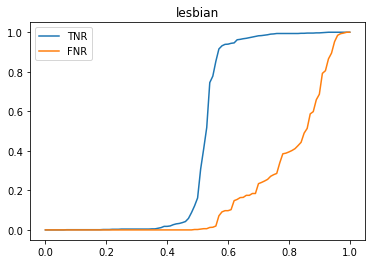

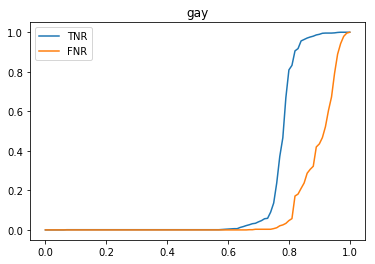

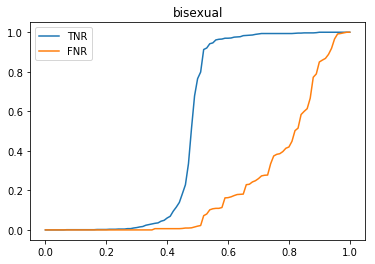

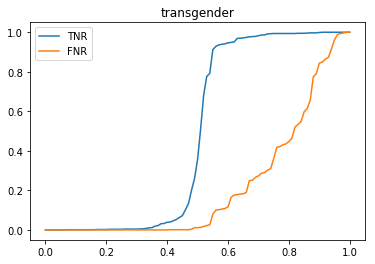

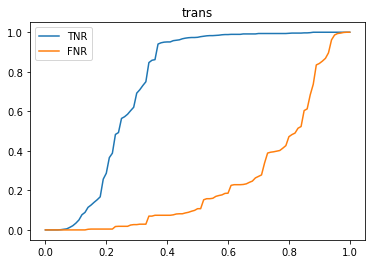

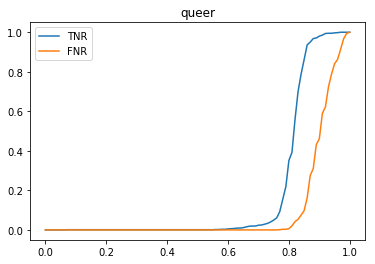

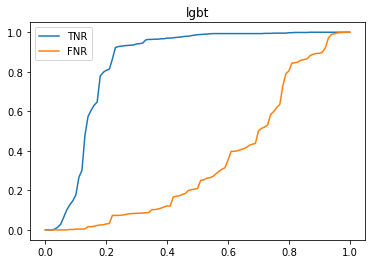

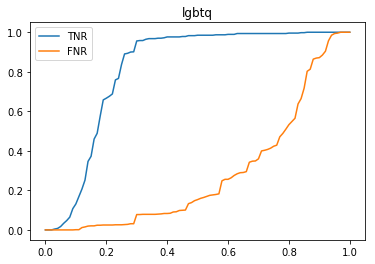

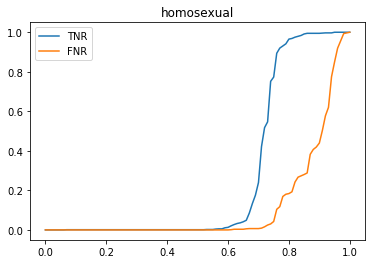

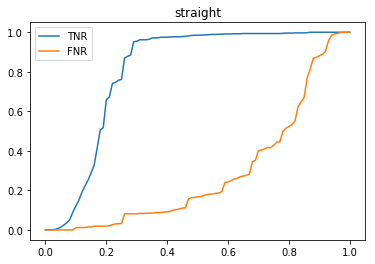

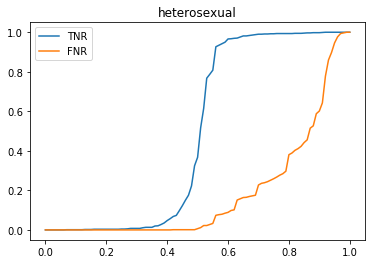

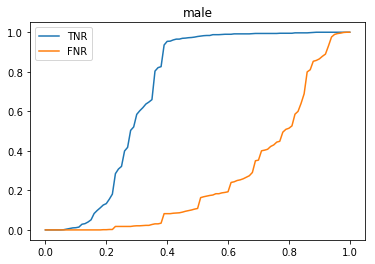

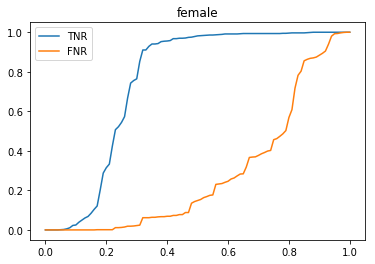

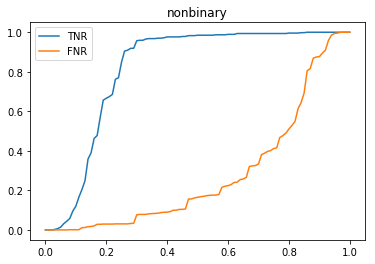

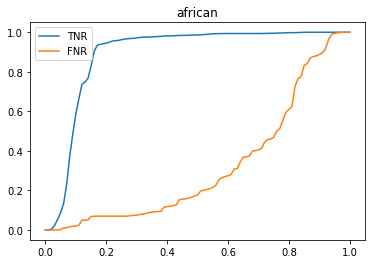

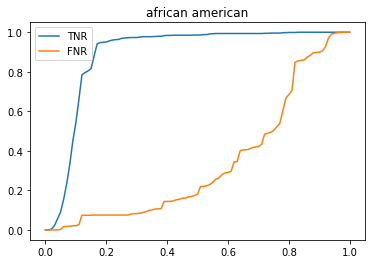

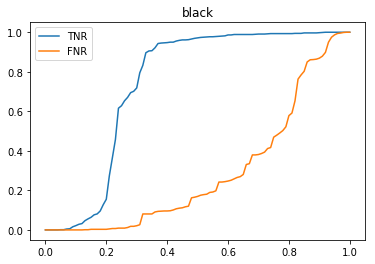

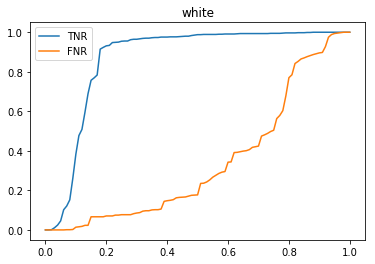

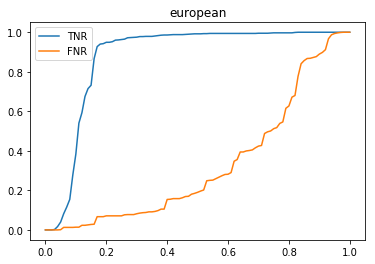

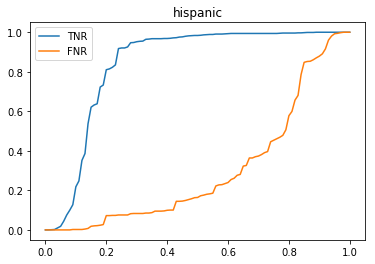

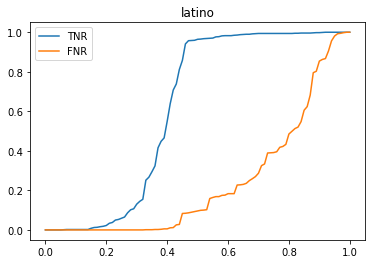

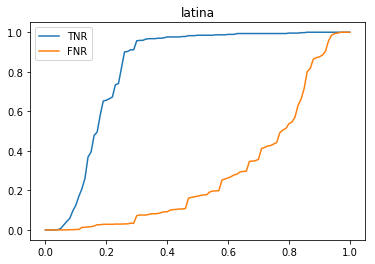

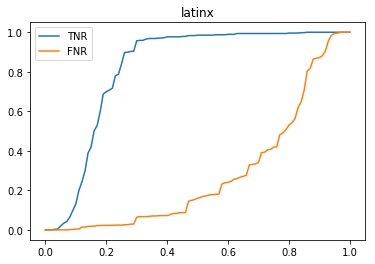

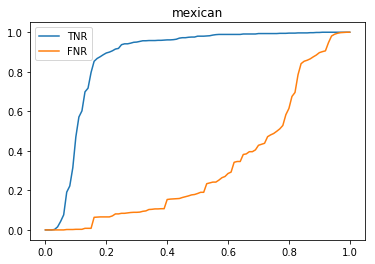

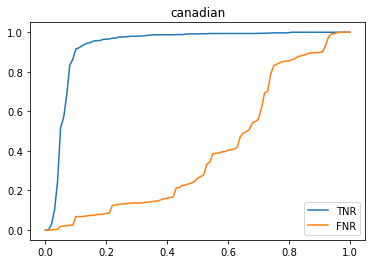

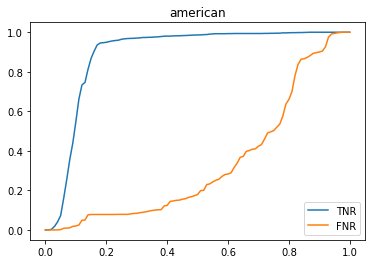

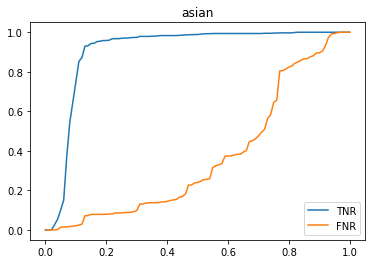

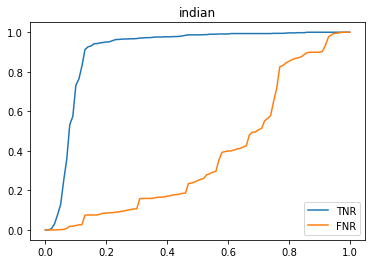

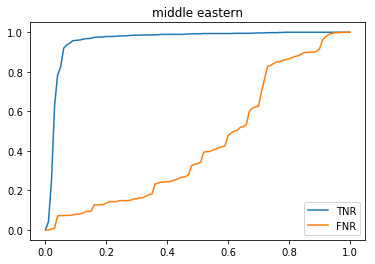

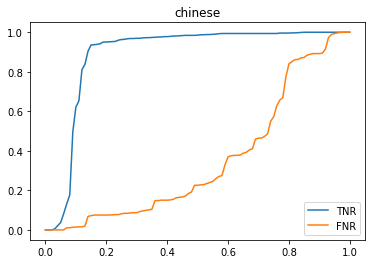

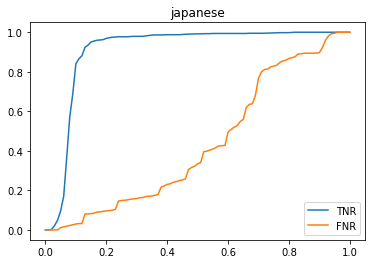

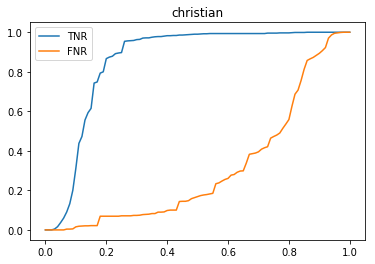

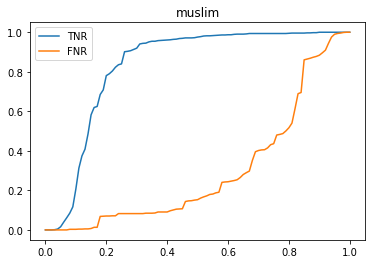

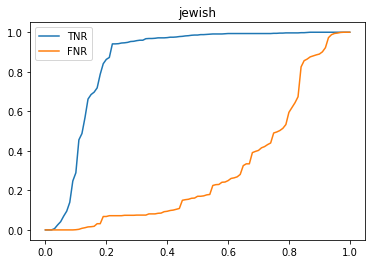

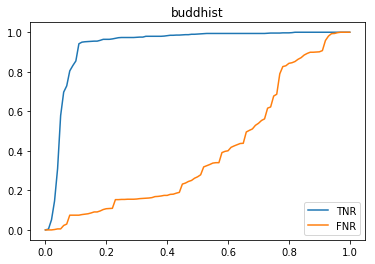

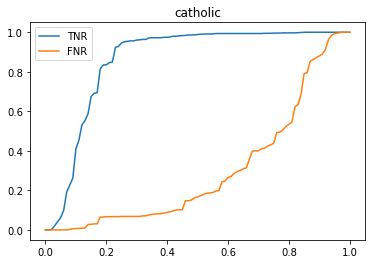

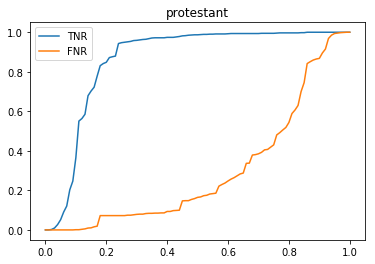

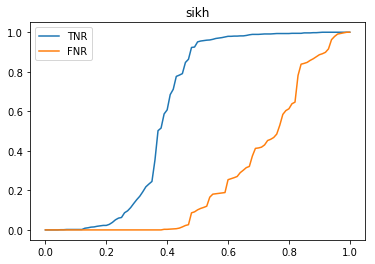

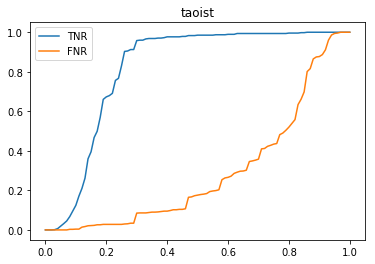

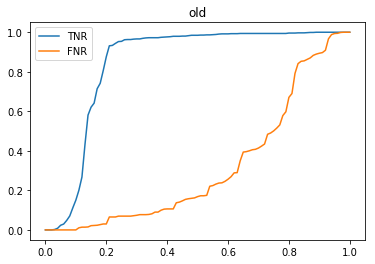

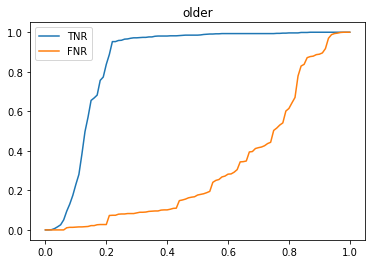

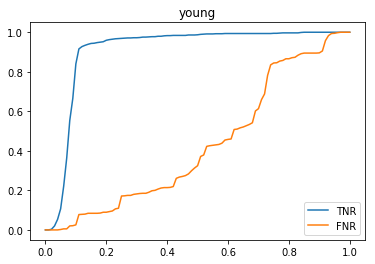

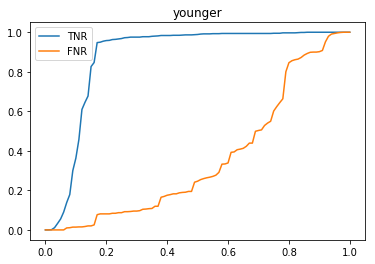

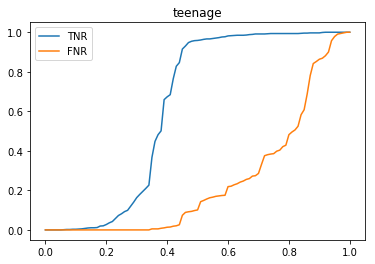

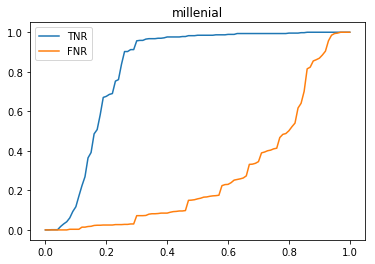

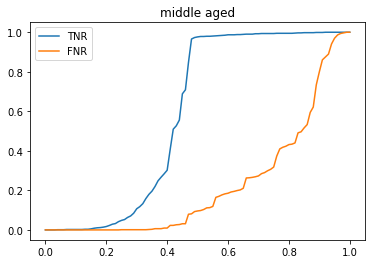

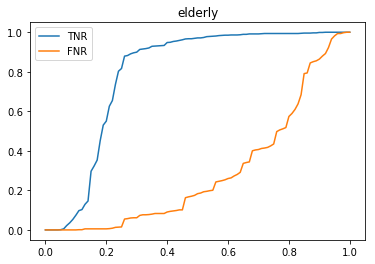

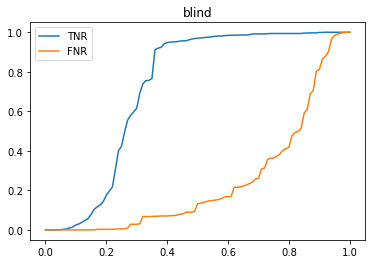

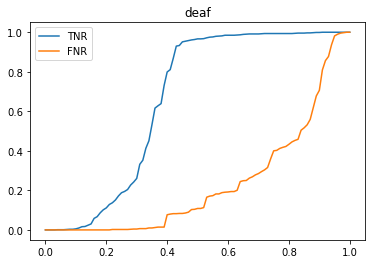

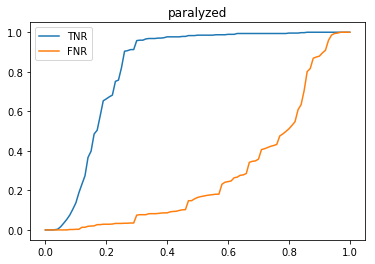

In [75]:
plot_terms_negative_rates(np.linspace(0, 1, 101))

### Equal Error Rate Threshold

In [48]:
def get_equal_error_rate(num_thresholds = 1001):
    thresholds = np.linspace(0, 1, num_thresholds)
    min_threshold = -1
    min_diff = -1
    min_confusion_matrix = -1
    for threshold in thresholds:
        confusion_matrix = confusion_matrix_counts(madlibs, 'score', 'label', threshold)
        difference = np.absolute(confusion_matrix['fn'] - confusion_matrix['fp'])
        if min_diff == -1 or difference < min_diff:
            min_threshold = threshold
            min_diff = difference
            min_confusion_matrix = confusion_matrix
    return min_threshold, min_confusion_matrix

In [49]:
%%time
get_equal_error_rate()

CPU times: user 11.6 s, sys: 72 ms, total: 11.7 s
Wall time: 11.7 s


(0.46800000000000003, {'fn': 6173, 'fp': 6249, 'tn': 38187, 'tp': 38874})

In [56]:
debias = pd.read_csv('../data/wiki_debias_random_train.csv')

In [57]:
debias.head()

,comment,is_toxic,logged_in,ns,rev_id,sample,split,toxicity,year
0,:::Is that a personal attack? ~,False,True,user,556478434.0,blocked,train,0.0,2013.0
1,"== The Shooter == Hey brother, you are not a...",False,True,user,303816484.0,blocked,train,0.0,2009.0
2,` == The Halo's RfA == {| |- | |valign=top|...,False,True,user,77269006.0,random,train,0.0,2006.0
3,: You've changed your point several times. So...,False,True,article,642873827.0,random,train,0.0,2015.0
4,The head of the CID in most police forces is a...,False,NaN,NaN,wikipedia_random631179_Criminal Investigation ...,debias_random,train,NaN,NaN
